In [1]:
!python --version

Python 3.10.4


In [2]:
import torch
torch.__version__

'2.5.1+cu124'

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all image file paths from the directory
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply the transform if provided
        if self.transform:
            image = self.transform(image)
        
        return image

In [5]:
# Define transformations (resize, crop, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize(160),  # Resize images to 64x64
    transforms.CenterCrop(160),  # Crop center to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load CelebA dataset from the specified directory
dataset_path = 'C:/Users/cynth/Dropbox/PC/Documents/College/PJT/Capstone PJT/GAN/A10'
dataset = CelebADataset(root_dir=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check how many images are loaded
print(f"Total number of images loaded: {len(dataset)}")

Total number of images loaded: 7399


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
import numpy as np


# Generator and Discriminator classes (same as previously described)
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_channels * 160 * 160),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 160, 160)  # Reshape to image format
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 160 * 160, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [8]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [12]:
# Training loop
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        save_generated_images(generator, epoch, device)

[Epoch 0/20] [Batch 0/1850] [D loss: 0.3971307575702667] [G loss: 0.6763980984687805]
[Epoch 0/20] [Batch 50/1850] [D loss: 0.43655452132225037] [G loss: 0.8624420166015625]
[Epoch 0/20] [Batch 100/1850] [D loss: 0.40430963039398193] [G loss: 0.705094575881958]
[Epoch 0/20] [Batch 150/1850] [D loss: 0.4074648320674896] [G loss: 0.7444847822189331]
[Epoch 0/20] [Batch 200/1850] [D loss: 0.3078309893608093] [G loss: 0.7486567497253418]
[Epoch 0/20] [Batch 250/1850] [D loss: 0.4475914239883423] [G loss: 0.579869270324707]
[Epoch 0/20] [Batch 300/1850] [D loss: 0.4802752733230591] [G loss: 0.5697956085205078]
[Epoch 0/20] [Batch 350/1850] [D loss: 0.3373398184776306] [G loss: 0.7821268439292908]
[Epoch 0/20] [Batch 400/1850] [D loss: 0.5323277711868286] [G loss: 0.38462066650390625]
[Epoch 0/20] [Batch 450/1850] [D loss: 0.35192644596099854] [G loss: 0.8793402910232544]
[Epoch 0/20] [Batch 500/1850] [D loss: 0.6472072601318359] [G loss: 0.4680757522583008]
[Epoch 0/20] [Batch 550/1850] [D 

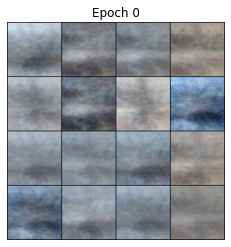

[Epoch 1/20] [Batch 0/1850] [D loss: 0.2664426565170288] [G loss: 1.3801178932189941]
[Epoch 1/20] [Batch 50/1850] [D loss: 0.29041415452957153] [G loss: 0.8654630184173584]
[Epoch 1/20] [Batch 100/1850] [D loss: 0.32150256633758545] [G loss: 2.150560140609741]
[Epoch 1/20] [Batch 150/1850] [D loss: 0.15265938639640808] [G loss: 1.9434560537338257]
[Epoch 1/20] [Batch 200/1850] [D loss: 0.22445760667324066] [G loss: 1.1335833072662354]
[Epoch 1/20] [Batch 250/1850] [D loss: 0.23229792714118958] [G loss: 0.8223716020584106]
[Epoch 1/20] [Batch 300/1850] [D loss: 0.3322869539260864] [G loss: 1.8502259254455566]
[Epoch 1/20] [Batch 350/1850] [D loss: 0.5901014804840088] [G loss: 1.7486276626586914]
[Epoch 1/20] [Batch 400/1850] [D loss: 0.49948689341545105] [G loss: 1.4315853118896484]
[Epoch 1/20] [Batch 450/1850] [D loss: 0.36015310883522034] [G loss: 1.1547703742980957]
[Epoch 1/20] [Batch 500/1850] [D loss: 0.21565666794776917] [G loss: 1.1742099523544312]
[Epoch 1/20] [Batch 550/1850

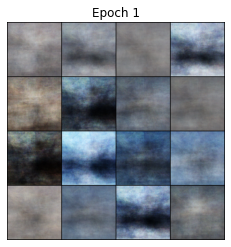

[Epoch 2/20] [Batch 0/1850] [D loss: 0.23494791984558105] [G loss: 1.6429585218429565]
[Epoch 2/20] [Batch 50/1850] [D loss: 0.7650012373924255] [G loss: 1.3155888319015503]
[Epoch 2/20] [Batch 100/1850] [D loss: 0.7624378800392151] [G loss: 1.0721251964569092]
[Epoch 2/20] [Batch 150/1850] [D loss: 0.5627917051315308] [G loss: 1.1235802173614502]
[Epoch 2/20] [Batch 200/1850] [D loss: 0.45703062415122986] [G loss: 2.317779541015625]
[Epoch 2/20] [Batch 250/1850] [D loss: 0.789974570274353] [G loss: 0.9319829940795898]
[Epoch 2/20] [Batch 300/1850] [D loss: 0.36221951246261597] [G loss: 0.1886756271123886]
[Epoch 2/20] [Batch 350/1850] [D loss: 0.2952752113342285] [G loss: 1.3199607133865356]
[Epoch 2/20] [Batch 400/1850] [D loss: 0.3690166175365448] [G loss: 1.3951799869537354]
[Epoch 2/20] [Batch 450/1850] [D loss: 0.41376620531082153] [G loss: 0.8440856337547302]
[Epoch 2/20] [Batch 500/1850] [D loss: 0.4716165363788605] [G loss: 1.6651532649993896]
[Epoch 2/20] [Batch 550/1850] [D 

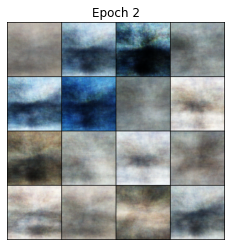

[Epoch 3/20] [Batch 0/1850] [D loss: 0.5719558596611023] [G loss: 1.1237608194351196]
[Epoch 3/20] [Batch 50/1850] [D loss: 0.6027106046676636] [G loss: 0.5722757577896118]
[Epoch 3/20] [Batch 100/1850] [D loss: 0.6601552963256836] [G loss: 2.2731380462646484]
[Epoch 3/20] [Batch 150/1850] [D loss: 0.6442043781280518] [G loss: 1.9785716533660889]
[Epoch 3/20] [Batch 200/1850] [D loss: 0.6548733711242676] [G loss: 0.9550741314888]
[Epoch 3/20] [Batch 250/1850] [D loss: 0.6500093340873718] [G loss: 0.8365035057067871]
[Epoch 3/20] [Batch 300/1850] [D loss: 0.7941871881484985] [G loss: 1.0573946237564087]
[Epoch 3/20] [Batch 350/1850] [D loss: 0.5042780637741089] [G loss: 1.5735018253326416]
[Epoch 3/20] [Batch 400/1850] [D loss: 0.4522612690925598] [G loss: 1.604952335357666]
[Epoch 3/20] [Batch 450/1850] [D loss: 0.29292237758636475] [G loss: 1.0231120586395264]
[Epoch 3/20] [Batch 500/1850] [D loss: 0.7778865694999695] [G loss: 1.015838861465454]
[Epoch 3/20] [Batch 550/1850] [D loss: 

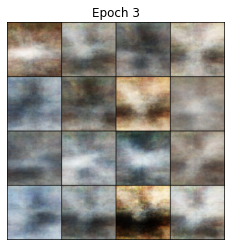

[Epoch 4/20] [Batch 0/1850] [D loss: 0.4370301067829132] [G loss: 1.4382925033569336]
[Epoch 4/20] [Batch 50/1850] [D loss: 0.37700140476226807] [G loss: 1.4621257781982422]
[Epoch 4/20] [Batch 100/1850] [D loss: 0.9699442386627197] [G loss: 0.9282190799713135]
[Epoch 4/20] [Batch 150/1850] [D loss: 0.654805064201355] [G loss: 1.449162483215332]
[Epoch 4/20] [Batch 200/1850] [D loss: 0.47905969619750977] [G loss: 1.1906059980392456]
[Epoch 4/20] [Batch 250/1850] [D loss: 0.6362227201461792] [G loss: 1.2210313081741333]
[Epoch 4/20] [Batch 300/1850] [D loss: 0.9677724242210388] [G loss: 1.332647442817688]
[Epoch 4/20] [Batch 350/1850] [D loss: 0.8789849281311035] [G loss: 1.4343894720077515]
[Epoch 4/20] [Batch 400/1850] [D loss: 0.8578450679779053] [G loss: 1.1983510255813599]
[Epoch 4/20] [Batch 450/1850] [D loss: 0.39928215742111206] [G loss: 2.317145824432373]
[Epoch 4/20] [Batch 500/1850] [D loss: 0.8777291178703308] [G loss: 1.6094321012496948]
[Epoch 4/20] [Batch 550/1850] [D los

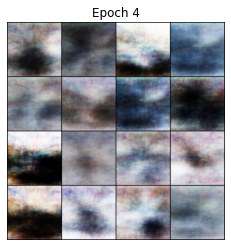

[Epoch 5/20] [Batch 0/1850] [D loss: 0.6331840753555298] [G loss: 1.228002667427063]
[Epoch 5/20] [Batch 50/1850] [D loss: 0.7070053815841675] [G loss: 1.4997315406799316]
[Epoch 5/20] [Batch 100/1850] [D loss: 0.8229240775108337] [G loss: 1.3072742223739624]
[Epoch 5/20] [Batch 150/1850] [D loss: 0.6469588279724121] [G loss: 0.9427721500396729]
[Epoch 5/20] [Batch 200/1850] [D loss: 0.3416396379470825] [G loss: 1.0712547302246094]
[Epoch 5/20] [Batch 250/1850] [D loss: 0.7128582000732422] [G loss: 0.7926393747329712]
[Epoch 5/20] [Batch 300/1850] [D loss: 0.7372879981994629] [G loss: 0.9900870323181152]
[Epoch 5/20] [Batch 350/1850] [D loss: 0.8479667901992798] [G loss: 0.9408864378929138]
[Epoch 5/20] [Batch 400/1850] [D loss: 0.4785199761390686] [G loss: 0.7513740658760071]
[Epoch 5/20] [Batch 450/1850] [D loss: 0.8750768303871155] [G loss: 0.8377472162246704]
[Epoch 5/20] [Batch 500/1850] [D loss: 0.25269779562950134] [G loss: 1.013532042503357]
[Epoch 5/20] [Batch 550/1850] [D los

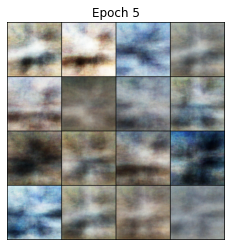

[Epoch 6/20] [Batch 0/1850] [D loss: 0.7360828518867493] [G loss: 0.6949090957641602]
[Epoch 6/20] [Batch 50/1850] [D loss: 0.4113146662712097] [G loss: 0.8567465543746948]
[Epoch 6/20] [Batch 100/1850] [D loss: 0.8057151436805725] [G loss: 0.5203956961631775]
[Epoch 6/20] [Batch 150/1850] [D loss: 0.4943091571331024] [G loss: 0.8847437500953674]
[Epoch 6/20] [Batch 200/1850] [D loss: 0.39520061016082764] [G loss: 1.0218030214309692]
[Epoch 6/20] [Batch 250/1850] [D loss: 0.5395991802215576] [G loss: 0.8673888444900513]
[Epoch 6/20] [Batch 300/1850] [D loss: 0.7219312191009521] [G loss: 0.9023808240890503]
[Epoch 6/20] [Batch 350/1850] [D loss: 0.7712860703468323] [G loss: 0.5782018899917603]
[Epoch 6/20] [Batch 400/1850] [D loss: 0.36747580766677856] [G loss: 1.4972707033157349]
[Epoch 6/20] [Batch 450/1850] [D loss: 0.6088493466377258] [G loss: 1.1037142276763916]
[Epoch 6/20] [Batch 500/1850] [D loss: 0.33194902539253235] [G loss: 1.5153491497039795]
[Epoch 6/20] [Batch 550/1850] [D

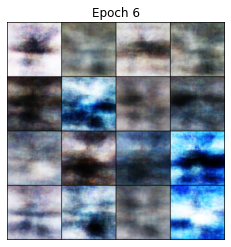

[Epoch 7/20] [Batch 0/1850] [D loss: 0.3619055151939392] [G loss: 1.247541904449463]
[Epoch 7/20] [Batch 50/1850] [D loss: 0.4596489369869232] [G loss: 1.3143808841705322]
[Epoch 7/20] [Batch 100/1850] [D loss: 0.7797334790229797] [G loss: 0.9278849363327026]
[Epoch 7/20] [Batch 150/1850] [D loss: 0.6133950352668762] [G loss: 0.7754366993904114]
[Epoch 7/20] [Batch 200/1850] [D loss: 0.5923085808753967] [G loss: 0.8740891218185425]
[Epoch 7/20] [Batch 250/1850] [D loss: 0.6292322874069214] [G loss: 1.196610927581787]
[Epoch 7/20] [Batch 300/1850] [D loss: 0.7440593242645264] [G loss: 0.7969189286231995]
[Epoch 7/20] [Batch 350/1850] [D loss: 0.9225549697875977] [G loss: 0.5283771753311157]
[Epoch 7/20] [Batch 400/1850] [D loss: 0.6665427684783936] [G loss: 1.710728645324707]
[Epoch 7/20] [Batch 450/1850] [D loss: 0.6605234146118164] [G loss: 1.1057510375976562]
[Epoch 7/20] [Batch 500/1850] [D loss: 0.5155404806137085] [G loss: 0.9644256830215454]
[Epoch 7/20] [Batch 550/1850] [D loss:

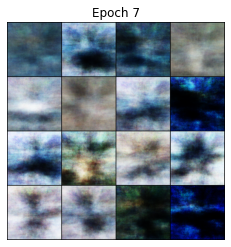

[Epoch 8/20] [Batch 0/1850] [D loss: 0.7605150938034058] [G loss: 0.8365457653999329]
[Epoch 8/20] [Batch 50/1850] [D loss: 0.6807429790496826] [G loss: 1.4243724346160889]
[Epoch 8/20] [Batch 100/1850] [D loss: 0.6349393129348755] [G loss: 1.1641145944595337]
[Epoch 8/20] [Batch 150/1850] [D loss: 0.6438164710998535] [G loss: 1.12315034866333]
[Epoch 8/20] [Batch 200/1850] [D loss: 0.3452562391757965] [G loss: 1.788385272026062]
[Epoch 8/20] [Batch 250/1850] [D loss: 1.0343997478485107] [G loss: 1.1292805671691895]
[Epoch 8/20] [Batch 300/1850] [D loss: 0.6268090009689331] [G loss: 1.0822129249572754]
[Epoch 8/20] [Batch 350/1850] [D loss: 0.4878644049167633] [G loss: 1.109910488128662]
[Epoch 8/20] [Batch 400/1850] [D loss: 0.7056111097335815] [G loss: 0.7906259298324585]
[Epoch 8/20] [Batch 450/1850] [D loss: 0.4780999422073364] [G loss: 1.5687034130096436]
[Epoch 8/20] [Batch 500/1850] [D loss: 0.900856614112854] [G loss: 0.88039231300354]
[Epoch 8/20] [Batch 550/1850] [D loss: 0.9

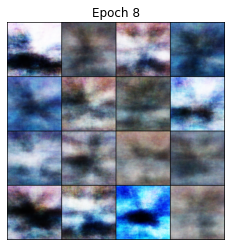

[Epoch 9/20] [Batch 0/1850] [D loss: 0.5855804681777954] [G loss: 0.8143837451934814]
[Epoch 9/20] [Batch 50/1850] [D loss: 0.7762472629547119] [G loss: 1.0823981761932373]
[Epoch 9/20] [Batch 100/1850] [D loss: 0.6571158170700073] [G loss: 0.6401005983352661]
[Epoch 9/20] [Batch 150/1850] [D loss: 0.5413849949836731] [G loss: 1.0248486995697021]
[Epoch 9/20] [Batch 200/1850] [D loss: 0.7212619781494141] [G loss: 0.9339430928230286]
[Epoch 9/20] [Batch 250/1850] [D loss: 0.4958301782608032] [G loss: 1.3806843757629395]
[Epoch 9/20] [Batch 300/1850] [D loss: 0.6623576879501343] [G loss: 0.554256021976471]
[Epoch 9/20] [Batch 350/1850] [D loss: 0.5717078447341919] [G loss: 1.6070518493652344]
[Epoch 9/20] [Batch 400/1850] [D loss: 0.7556447386741638] [G loss: 1.3864846229553223]
[Epoch 9/20] [Batch 450/1850] [D loss: 0.7572405338287354] [G loss: 0.7878072261810303]
[Epoch 9/20] [Batch 500/1850] [D loss: 0.607455849647522] [G loss: 1.4070335626602173]
[Epoch 9/20] [Batch 550/1850] [D loss

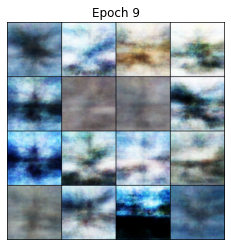

[Epoch 10/20] [Batch 0/1850] [D loss: 0.6547628045082092] [G loss: 0.8346503973007202]
[Epoch 10/20] [Batch 50/1850] [D loss: 0.5422875881195068] [G loss: 1.275653600692749]
[Epoch 10/20] [Batch 100/1850] [D loss: 0.847985029220581] [G loss: 0.7829749584197998]
[Epoch 10/20] [Batch 150/1850] [D loss: 1.1186048984527588] [G loss: 0.8318480253219604]
[Epoch 10/20] [Batch 200/1850] [D loss: 0.5985655784606934] [G loss: 0.7735277414321899]
[Epoch 10/20] [Batch 250/1850] [D loss: 0.4666750431060791] [G loss: 1.0811710357666016]
[Epoch 10/20] [Batch 300/1850] [D loss: 0.3961007595062256] [G loss: 1.0043121576309204]
[Epoch 10/20] [Batch 350/1850] [D loss: 0.8097084164619446] [G loss: 0.6724728941917419]
[Epoch 10/20] [Batch 400/1850] [D loss: 0.6519612669944763] [G loss: 1.199193000793457]
[Epoch 10/20] [Batch 450/1850] [D loss: 0.8067270517349243] [G loss: 1.6768016815185547]
[Epoch 10/20] [Batch 500/1850] [D loss: 0.8135613203048706] [G loss: 0.9384095668792725]
[Epoch 10/20] [Batch 550/18

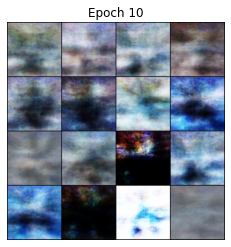

[Epoch 11/20] [Batch 0/1850] [D loss: 0.4713732600212097] [G loss: 0.9551631808280945]
[Epoch 11/20] [Batch 50/1850] [D loss: 0.7882459163665771] [G loss: 0.9993860721588135]
[Epoch 11/20] [Batch 100/1850] [D loss: 0.5754528045654297] [G loss: 1.106191635131836]
[Epoch 11/20] [Batch 150/1850] [D loss: 0.29186952114105225] [G loss: 0.9142240285873413]
[Epoch 11/20] [Batch 200/1850] [D loss: 0.575614333152771] [G loss: 0.602400541305542]
[Epoch 11/20] [Batch 250/1850] [D loss: 0.47773513197898865] [G loss: 0.7283480167388916]
[Epoch 11/20] [Batch 300/1850] [D loss: 0.7254021763801575] [G loss: 0.9530515670776367]
[Epoch 11/20] [Batch 350/1850] [D loss: 0.5782904624938965] [G loss: 0.9865427613258362]
[Epoch 11/20] [Batch 400/1850] [D loss: 0.5937092304229736] [G loss: 1.417904257774353]
[Epoch 11/20] [Batch 450/1850] [D loss: 0.569891095161438] [G loss: 0.9879509806632996]
[Epoch 11/20] [Batch 500/1850] [D loss: 0.5954289436340332] [G loss: 0.9764305353164673]
[Epoch 11/20] [Batch 550/18

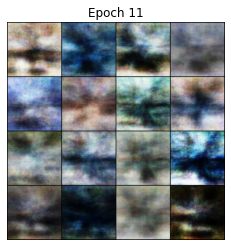

[Epoch 12/20] [Batch 0/1850] [D loss: 0.5202112793922424] [G loss: 1.3714519739151]
[Epoch 12/20] [Batch 50/1850] [D loss: 0.6071114540100098] [G loss: 0.36084258556365967]
[Epoch 12/20] [Batch 100/1850] [D loss: 0.714301347732544] [G loss: 0.9392877221107483]
[Epoch 12/20] [Batch 150/1850] [D loss: 0.4003998041152954] [G loss: 0.7632825374603271]
[Epoch 12/20] [Batch 200/1850] [D loss: 0.7352602481842041] [G loss: 0.9728227853775024]
[Epoch 12/20] [Batch 250/1850] [D loss: 0.5611908435821533] [G loss: 0.9462083578109741]
[Epoch 12/20] [Batch 300/1850] [D loss: 0.6123701930046082] [G loss: 1.0796514749526978]
[Epoch 12/20] [Batch 350/1850] [D loss: 0.799156665802002] [G loss: 1.1579837799072266]
[Epoch 12/20] [Batch 400/1850] [D loss: 0.7247501015663147] [G loss: 0.9741517305374146]
[Epoch 12/20] [Batch 450/1850] [D loss: 0.9132862687110901] [G loss: 1.1886188983917236]
[Epoch 12/20] [Batch 500/1850] [D loss: 0.5348067283630371] [G loss: 1.3002572059631348]
[Epoch 12/20] [Batch 550/185

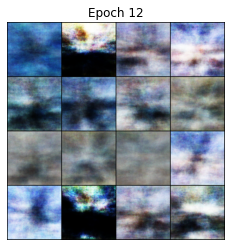

[Epoch 13/20] [Batch 0/1850] [D loss: 0.45289596915245056] [G loss: 1.1631051301956177]
[Epoch 13/20] [Batch 50/1850] [D loss: 1.0434383153915405] [G loss: 0.6209226846694946]
[Epoch 13/20] [Batch 100/1850] [D loss: 0.4164156913757324] [G loss: 0.9452314376831055]
[Epoch 13/20] [Batch 150/1850] [D loss: 0.7491462230682373] [G loss: 0.9026761054992676]
[Epoch 13/20] [Batch 200/1850] [D loss: 0.3291189670562744] [G loss: 1.1696357727050781]
[Epoch 13/20] [Batch 250/1850] [D loss: 0.8300772905349731] [G loss: 0.9500616788864136]
[Epoch 13/20] [Batch 300/1850] [D loss: 0.8468748927116394] [G loss: 1.069830298423767]
[Epoch 13/20] [Batch 350/1850] [D loss: 0.45852571725845337] [G loss: 1.1225658655166626]
[Epoch 13/20] [Batch 400/1850] [D loss: 0.7070777416229248] [G loss: 0.8798519372940063]
[Epoch 13/20] [Batch 450/1850] [D loss: 0.6910552978515625] [G loss: 0.6662216782569885]
[Epoch 13/20] [Batch 500/1850] [D loss: 0.7759457230567932] [G loss: 1.5239481925964355]
[Epoch 13/20] [Batch 55

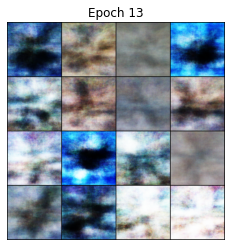

[Epoch 14/20] [Batch 0/1850] [D loss: 0.6860023736953735] [G loss: 1.0977835655212402]
[Epoch 14/20] [Batch 50/1850] [D loss: 0.6113208532333374] [G loss: 1.0608912706375122]
[Epoch 14/20] [Batch 100/1850] [D loss: 0.6448273658752441] [G loss: 0.8282781839370728]
[Epoch 14/20] [Batch 150/1850] [D loss: 0.646571695804596] [G loss: 1.0490933656692505]
[Epoch 14/20] [Batch 200/1850] [D loss: 0.6421917080879211] [G loss: 0.6842197775840759]
[Epoch 14/20] [Batch 250/1850] [D loss: 0.897542417049408] [G loss: 1.1664788722991943]
[Epoch 14/20] [Batch 300/1850] [D loss: 0.6741136908531189] [G loss: 0.8215533494949341]
[Epoch 14/20] [Batch 350/1850] [D loss: 0.33147531747817993] [G loss: 1.0311927795410156]
[Epoch 14/20] [Batch 400/1850] [D loss: 0.5871938467025757] [G loss: 0.7557905912399292]
[Epoch 14/20] [Batch 450/1850] [D loss: 0.6496768593788147] [G loss: 0.7754926681518555]
[Epoch 14/20] [Batch 500/1850] [D loss: 0.5154693126678467] [G loss: 1.3199115991592407]
[Epoch 14/20] [Batch 550/

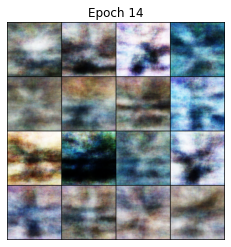

[Epoch 15/20] [Batch 0/1850] [D loss: 0.5345484018325806] [G loss: 1.2265863418579102]
[Epoch 15/20] [Batch 50/1850] [D loss: 0.7276656627655029] [G loss: 0.9247047901153564]
[Epoch 15/20] [Batch 100/1850] [D loss: 0.6028291583061218] [G loss: 0.7618211507797241]
[Epoch 15/20] [Batch 150/1850] [D loss: 0.7406023740768433] [G loss: 0.7846179008483887]
[Epoch 15/20] [Batch 200/1850] [D loss: 0.6605031490325928] [G loss: 0.9652389883995056]
[Epoch 15/20] [Batch 250/1850] [D loss: 0.53725266456604] [G loss: 1.0328607559204102]
[Epoch 15/20] [Batch 300/1850] [D loss: 0.5440679788589478] [G loss: 0.8609542846679688]
[Epoch 15/20] [Batch 350/1850] [D loss: 0.8270039558410645] [G loss: 0.9322525858879089]
[Epoch 15/20] [Batch 400/1850] [D loss: 0.46605169773101807] [G loss: 0.7425686120986938]
[Epoch 15/20] [Batch 450/1850] [D loss: 0.5977483987808228] [G loss: 0.9232494831085205]
[Epoch 15/20] [Batch 500/1850] [D loss: 0.5481672286987305] [G loss: 1.1717288494110107]
[Epoch 15/20] [Batch 550/

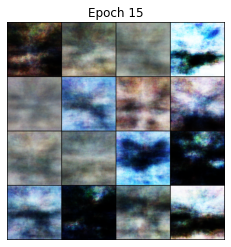

[Epoch 16/20] [Batch 0/1850] [D loss: 0.6166340112686157] [G loss: 1.505553960800171]
[Epoch 16/20] [Batch 50/1850] [D loss: 0.6838467717170715] [G loss: 1.1886951923370361]
[Epoch 16/20] [Batch 100/1850] [D loss: 0.9455669522285461] [G loss: 1.10725998878479]
[Epoch 16/20] [Batch 150/1850] [D loss: 1.2518694400787354] [G loss: 1.2437200546264648]
[Epoch 16/20] [Batch 200/1850] [D loss: 0.6449751853942871] [G loss: 0.8214324116706848]
[Epoch 16/20] [Batch 250/1850] [D loss: 0.352531760931015] [G loss: 1.2786036729812622]
[Epoch 16/20] [Batch 300/1850] [D loss: 0.6199373006820679] [G loss: 0.8311911821365356]
[Epoch 16/20] [Batch 350/1850] [D loss: 0.3219218850135803] [G loss: 1.25786554813385]
[Epoch 16/20] [Batch 400/1850] [D loss: 0.4768246114253998] [G loss: 1.2729904651641846]
[Epoch 16/20] [Batch 450/1850] [D loss: 0.531271755695343] [G loss: 0.7818199396133423]
[Epoch 16/20] [Batch 500/1850] [D loss: 0.6638737320899963] [G loss: 0.6841787099838257]
[Epoch 16/20] [Batch 550/1850] 

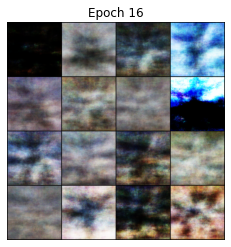

[Epoch 17/20] [Batch 0/1850] [D loss: 0.727098286151886] [G loss: 0.5983902215957642]
[Epoch 17/20] [Batch 50/1850] [D loss: 0.6735993027687073] [G loss: 0.7411739826202393]
[Epoch 17/20] [Batch 100/1850] [D loss: 0.6916941404342651] [G loss: 1.235815405845642]
[Epoch 17/20] [Batch 150/1850] [D loss: 0.7235018014907837] [G loss: 0.8020771741867065]
[Epoch 17/20] [Batch 200/1850] [D loss: 0.7000727653503418] [G loss: 1.2533124685287476]
[Epoch 17/20] [Batch 250/1850] [D loss: 0.6359180212020874] [G loss: 0.9085221290588379]
[Epoch 17/20] [Batch 300/1850] [D loss: 0.8546427488327026] [G loss: 0.4768722653388977]
[Epoch 17/20] [Batch 350/1850] [D loss: 0.7957191467285156] [G loss: 0.7263860106468201]
[Epoch 17/20] [Batch 400/1850] [D loss: 0.7081128358840942] [G loss: 1.0377806425094604]
[Epoch 17/20] [Batch 450/1850] [D loss: 0.547684907913208] [G loss: 1.2689775228500366]
[Epoch 17/20] [Batch 500/1850] [D loss: 0.572567880153656] [G loss: 1.0930155515670776]
[Epoch 17/20] [Batch 550/185

KeyboardInterrupt: 

In [11]:
# Start training
train(generator, discriminator, dataloader, epochs=20)

In [15]:
def save_generated_images(generator, epoch, device, num_images=8):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

[Epoch 0/10] [Batch 0/1850] [D loss: 0.6534538865089417] [G loss: 1.434579849243164]
[Epoch 0/10] [Batch 50/1850] [D loss: 0.4838177561759949] [G loss: 1.0570454597473145]
[Epoch 0/10] [Batch 100/1850] [D loss: 0.6144043803215027] [G loss: 1.4151957035064697]
[Epoch 0/10] [Batch 150/1850] [D loss: 0.5554825067520142] [G loss: 1.040565013885498]
[Epoch 0/10] [Batch 200/1850] [D loss: 0.6849197149276733] [G loss: 1.136685848236084]
[Epoch 0/10] [Batch 250/1850] [D loss: 0.7213526964187622] [G loss: 0.5486146211624146]
[Epoch 0/10] [Batch 300/1850] [D loss: 0.7871856689453125] [G loss: 0.7826043963432312]
[Epoch 0/10] [Batch 350/1850] [D loss: 0.747503936290741] [G loss: 0.4479009509086609]
[Epoch 0/10] [Batch 400/1850] [D loss: 0.629321277141571] [G loss: 0.8054400682449341]
[Epoch 0/10] [Batch 450/1850] [D loss: 0.6185481548309326] [G loss: 0.7969990968704224]
[Epoch 0/10] [Batch 500/1850] [D loss: 0.7436577081680298] [G loss: 1.0898163318634033]
[Epoch 0/10] [Batch 550/1850] [D loss: 0

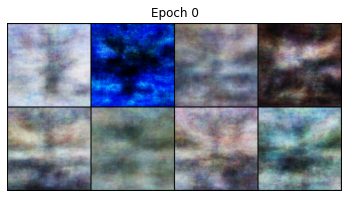

[Epoch 1/10] [Batch 0/1850] [D loss: 0.7999630570411682] [G loss: 1.1350929737091064]
[Epoch 1/10] [Batch 50/1850] [D loss: 0.3612444996833801] [G loss: 1.4182045459747314]
[Epoch 1/10] [Batch 100/1850] [D loss: 0.735916018486023] [G loss: 1.2176004648208618]
[Epoch 1/10] [Batch 150/1850] [D loss: 0.5286914706230164] [G loss: 0.863074779510498]
[Epoch 1/10] [Batch 200/1850] [D loss: 0.7402844429016113] [G loss: 0.7823892831802368]
[Epoch 1/10] [Batch 250/1850] [D loss: 0.8730779886245728] [G loss: 0.8520569801330566]
[Epoch 1/10] [Batch 300/1850] [D loss: 0.5932421684265137] [G loss: 0.9702438712120056]
[Epoch 1/10] [Batch 350/1850] [D loss: 0.6434623003005981] [G loss: 1.035328984260559]
[Epoch 1/10] [Batch 400/1850] [D loss: 0.767564594745636] [G loss: 1.2908626794815063]
[Epoch 1/10] [Batch 450/1850] [D loss: 0.6845897436141968] [G loss: 1.8833940029144287]
[Epoch 1/10] [Batch 500/1850] [D loss: 0.4750627875328064] [G loss: 0.8965708017349243]
[Epoch 1/10] [Batch 550/1850] [D loss: 

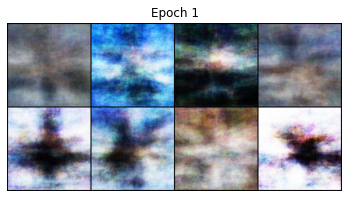

[Epoch 2/10] [Batch 0/1850] [D loss: 0.6077696084976196] [G loss: 0.8265842199325562]
[Epoch 2/10] [Batch 50/1850] [D loss: 0.6903233528137207] [G loss: 1.1517019271850586]
[Epoch 2/10] [Batch 100/1850] [D loss: 0.6004561185836792] [G loss: 0.7477656006813049]
[Epoch 2/10] [Batch 150/1850] [D loss: 0.5403204560279846] [G loss: 0.9272940158843994]
[Epoch 2/10] [Batch 200/1850] [D loss: 0.7969094514846802] [G loss: 0.7024836540222168]
[Epoch 2/10] [Batch 250/1850] [D loss: 0.4320700764656067] [G loss: 0.8749197721481323]
[Epoch 2/10] [Batch 300/1850] [D loss: 0.37656170129776] [G loss: 1.3122609853744507]
[Epoch 2/10] [Batch 350/1850] [D loss: 0.7142603397369385] [G loss: 1.1669808626174927]
[Epoch 2/10] [Batch 400/1850] [D loss: 0.704768717288971] [G loss: 1.1500771045684814]
[Epoch 2/10] [Batch 450/1850] [D loss: 0.4438198208808899] [G loss: 1.1589910984039307]
[Epoch 2/10] [Batch 500/1850] [D loss: 0.5626077651977539] [G loss: 0.7909111976623535]
[Epoch 2/10] [Batch 550/1850] [D loss:

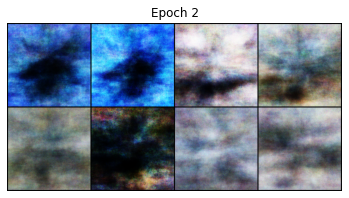

[Epoch 3/10] [Batch 0/1850] [D loss: 0.7204216718673706] [G loss: 0.7947583198547363]
[Epoch 3/10] [Batch 50/1850] [D loss: 0.5989784002304077] [G loss: 0.7970234155654907]
[Epoch 3/10] [Batch 100/1850] [D loss: 0.5092030763626099] [G loss: 0.6655239462852478]
[Epoch 3/10] [Batch 150/1850] [D loss: 0.8111529350280762] [G loss: 0.906680703163147]
[Epoch 3/10] [Batch 200/1850] [D loss: 0.6569957137107849] [G loss: 0.8000903129577637]
[Epoch 3/10] [Batch 250/1850] [D loss: 0.7676717042922974] [G loss: 0.7438773512840271]
[Epoch 3/10] [Batch 300/1850] [D loss: 0.8086068630218506] [G loss: 0.7539911270141602]
[Epoch 3/10] [Batch 350/1850] [D loss: 0.41381406784057617] [G loss: 1.3875072002410889]
[Epoch 3/10] [Batch 400/1850] [D loss: 0.6021208763122559] [G loss: 0.9018326997756958]
[Epoch 3/10] [Batch 450/1850] [D loss: 0.6877092123031616] [G loss: 1.0340231657028198]
[Epoch 3/10] [Batch 500/1850] [D loss: 0.581367015838623] [G loss: 0.6411900520324707]
[Epoch 3/10] [Batch 550/1850] [D los

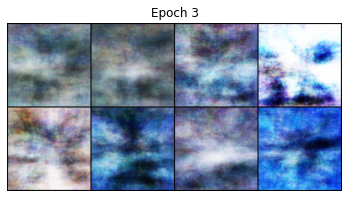

[Epoch 4/10] [Batch 0/1850] [D loss: 0.7924137115478516] [G loss: 0.7209587097167969]
[Epoch 4/10] [Batch 50/1850] [D loss: 0.4718146026134491] [G loss: 0.6205477714538574]
[Epoch 4/10] [Batch 100/1850] [D loss: 0.6228851079940796] [G loss: 0.8881722688674927]
[Epoch 4/10] [Batch 150/1850] [D loss: 0.7285454273223877] [G loss: 1.315065860748291]
[Epoch 4/10] [Batch 200/1850] [D loss: 0.644631028175354] [G loss: 0.9738731384277344]
[Epoch 4/10] [Batch 250/1850] [D loss: 0.520111083984375] [G loss: 1.1312713623046875]
[Epoch 4/10] [Batch 300/1850] [D loss: 0.7078930139541626] [G loss: 1.5045008659362793]
[Epoch 4/10] [Batch 350/1850] [D loss: 0.6258634328842163] [G loss: 0.925614595413208]
[Epoch 4/10] [Batch 400/1850] [D loss: 0.7203447222709656] [G loss: 0.8831690549850464]
[Epoch 4/10] [Batch 450/1850] [D loss: 0.5357869863510132] [G loss: 1.5937926769256592]
[Epoch 4/10] [Batch 500/1850] [D loss: 0.8109430074691772] [G loss: 1.4451665878295898]
[Epoch 4/10] [Batch 550/1850] [D loss: 

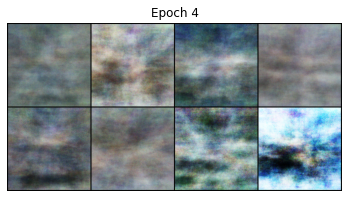

[Epoch 5/10] [Batch 0/1850] [D loss: 0.8434842824935913] [G loss: 0.9231863617897034]
[Epoch 5/10] [Batch 50/1850] [D loss: 0.6938948035240173] [G loss: 1.080012559890747]
[Epoch 5/10] [Batch 100/1850] [D loss: 0.7095445990562439] [G loss: 0.8661555051803589]
[Epoch 5/10] [Batch 150/1850] [D loss: 0.6158766746520996] [G loss: 0.9226248860359192]
[Epoch 5/10] [Batch 200/1850] [D loss: 0.60141921043396] [G loss: 1.005259394645691]
[Epoch 5/10] [Batch 250/1850] [D loss: 0.46031486988067627] [G loss: 0.9241694211959839]
[Epoch 5/10] [Batch 300/1850] [D loss: 0.5118286609649658] [G loss: 0.9165584444999695]
[Epoch 5/10] [Batch 350/1850] [D loss: 0.4860467314720154] [G loss: 0.7890282869338989]
[Epoch 5/10] [Batch 400/1850] [D loss: 0.5875586271286011] [G loss: 0.8265474438667297]
[Epoch 5/10] [Batch 450/1850] [D loss: 0.4376131594181061] [G loss: 0.7288907766342163]
[Epoch 5/10] [Batch 500/1850] [D loss: 1.1340335607528687] [G loss: 0.7284577488899231]
[Epoch 5/10] [Batch 550/1850] [D loss:

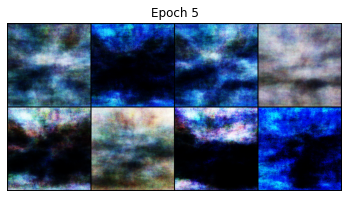

[Epoch 6/10] [Batch 0/1850] [D loss: 0.7342662215232849] [G loss: 0.731787919998169]
[Epoch 6/10] [Batch 50/1850] [D loss: 0.5427242517471313] [G loss: 0.8666999340057373]
[Epoch 6/10] [Batch 100/1850] [D loss: 0.4548749625682831] [G loss: 0.8562898635864258]
[Epoch 6/10] [Batch 150/1850] [D loss: 0.7562059164047241] [G loss: 1.9022800922393799]
[Epoch 6/10] [Batch 200/1850] [D loss: 0.7891230583190918] [G loss: 1.089311957359314]
[Epoch 6/10] [Batch 250/1850] [D loss: 0.35068076848983765] [G loss: 1.1117663383483887]
[Epoch 6/10] [Batch 300/1850] [D loss: 0.3572646379470825] [G loss: 0.7373666167259216]
[Epoch 6/10] [Batch 350/1850] [D loss: 0.7889934778213501] [G loss: 1.257513403892517]
[Epoch 6/10] [Batch 400/1850] [D loss: 0.44398531317710876] [G loss: 0.8238394260406494]
[Epoch 6/10] [Batch 450/1850] [D loss: 0.8948085904121399] [G loss: 1.2591302394866943]
[Epoch 6/10] [Batch 500/1850] [D loss: 0.5032442808151245] [G loss: 1.0788465738296509]
[Epoch 6/10] [Batch 550/1850] [D los

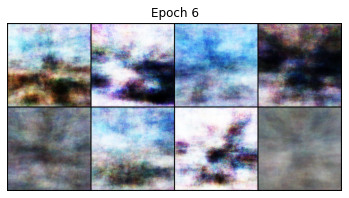

[Epoch 7/10] [Batch 0/1850] [D loss: 0.49780285358428955] [G loss: 0.7742393016815186]
[Epoch 7/10] [Batch 50/1850] [D loss: 0.8383840322494507] [G loss: 1.1097397804260254]
[Epoch 7/10] [Batch 100/1850] [D loss: 0.6495559811592102] [G loss: 1.028465747833252]
[Epoch 7/10] [Batch 150/1850] [D loss: 0.8445419073104858] [G loss: 0.8529849648475647]
[Epoch 7/10] [Batch 200/1850] [D loss: 0.6641921401023865] [G loss: 1.226099967956543]
[Epoch 7/10] [Batch 250/1850] [D loss: 0.7214299440383911] [G loss: 0.9404170513153076]
[Epoch 7/10] [Batch 300/1850] [D loss: 0.7470798492431641] [G loss: 0.8326238989830017]
[Epoch 7/10] [Batch 350/1850] [D loss: 0.6417770385742188] [G loss: 1.3447606563568115]
[Epoch 7/10] [Batch 400/1850] [D loss: 0.527640700340271] [G loss: 1.9655101299285889]
[Epoch 7/10] [Batch 450/1850] [D loss: 0.637607753276825] [G loss: 1.0050206184387207]
[Epoch 7/10] [Batch 500/1850] [D loss: 0.7098245620727539] [G loss: 0.7870581746101379]
[Epoch 7/10] [Batch 550/1850] [D loss:

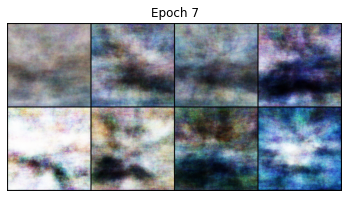

[Epoch 8/10] [Batch 0/1850] [D loss: 0.5747092962265015] [G loss: 1.1278926134109497]
[Epoch 8/10] [Batch 50/1850] [D loss: 0.6259923577308655] [G loss: 1.0660383701324463]
[Epoch 8/10] [Batch 100/1850] [D loss: 0.5455697774887085] [G loss: 1.3137822151184082]
[Epoch 8/10] [Batch 150/1850] [D loss: 0.6532185077667236] [G loss: 1.7259628772735596]
[Epoch 8/10] [Batch 200/1850] [D loss: 0.815790593624115] [G loss: 1.0525819063186646]
[Epoch 8/10] [Batch 250/1850] [D loss: 0.6601970791816711] [G loss: 1.3018755912780762]
[Epoch 8/10] [Batch 300/1850] [D loss: 0.5566922426223755] [G loss: 0.7674803137779236]
[Epoch 8/10] [Batch 350/1850] [D loss: 0.661989688873291] [G loss: 1.3495912551879883]
[Epoch 8/10] [Batch 400/1850] [D loss: 0.4523140788078308] [G loss: 1.0164960622787476]
[Epoch 8/10] [Batch 450/1850] [D loss: 0.9604991674423218] [G loss: 1.0712478160858154]
[Epoch 8/10] [Batch 500/1850] [D loss: 0.9118648171424866] [G loss: 0.9383476376533508]
[Epoch 8/10] [Batch 550/1850] [D loss

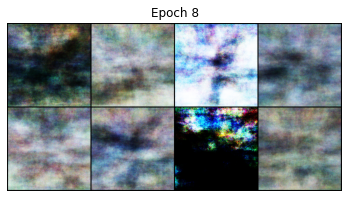

[Epoch 9/10] [Batch 0/1850] [D loss: 0.5624613761901855] [G loss: 0.8442212343215942]
[Epoch 9/10] [Batch 50/1850] [D loss: 0.5427932739257812] [G loss: 1.2105605602264404]
[Epoch 9/10] [Batch 100/1850] [D loss: 0.5589621663093567] [G loss: 0.7914371490478516]
[Epoch 9/10] [Batch 150/1850] [D loss: 0.8127328157424927] [G loss: 0.6453303098678589]
[Epoch 9/10] [Batch 200/1850] [D loss: 0.5967098474502563] [G loss: 1.0856603384017944]
[Epoch 9/10] [Batch 250/1850] [D loss: 0.7270591259002686] [G loss: 0.5838273763656616]
[Epoch 9/10] [Batch 300/1850] [D loss: 0.7706015110015869] [G loss: 1.0639150142669678]
[Epoch 9/10] [Batch 350/1850] [D loss: 0.5433042645454407] [G loss: 1.208072543144226]
[Epoch 9/10] [Batch 400/1850] [D loss: 0.5973397493362427] [G loss: 0.9387125372886658]
[Epoch 9/10] [Batch 450/1850] [D loss: 0.643109142780304] [G loss: 1.2549469470977783]
[Epoch 9/10] [Batch 500/1850] [D loss: 0.5487368106842041] [G loss: 0.7282954454421997]
[Epoch 9/10] [Batch 550/1850] [D loss

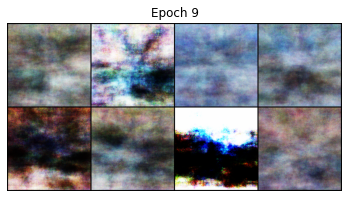

In [16]:
# Start training
train(generator, discriminator, dataloader, epochs=10)

[Epoch 0/10] [Batch 0/1850] [D loss: 0.6675221920013428] [G loss: 1.0430567264556885]
[Epoch 0/10] [Batch 50/1850] [D loss: 0.6706383228302002] [G loss: 0.8345932364463806]
[Epoch 0/10] [Batch 100/1850] [D loss: 1.0704883337020874] [G loss: 0.5963339805603027]
[Epoch 0/10] [Batch 150/1850] [D loss: 0.58680260181427] [G loss: 0.9585407376289368]
[Epoch 0/10] [Batch 200/1850] [D loss: 0.35770660638809204] [G loss: 0.7764201164245605]
[Epoch 0/10] [Batch 250/1850] [D loss: 0.9646810293197632] [G loss: 1.1455814838409424]
[Epoch 0/10] [Batch 300/1850] [D loss: 0.5244060158729553] [G loss: 1.133852243423462]
[Epoch 0/10] [Batch 350/1850] [D loss: 0.6465526819229126] [G loss: 0.6986426115036011]
[Epoch 0/10] [Batch 400/1850] [D loss: 0.8121803998947144] [G loss: 0.932416558265686]
[Epoch 0/10] [Batch 450/1850] [D loss: 0.4096030294895172] [G loss: 0.6540999412536621]
[Epoch 0/10] [Batch 500/1850] [D loss: 0.7527548670768738] [G loss: 0.6561170220375061]
[Epoch 0/10] [Batch 550/1850] [D loss:

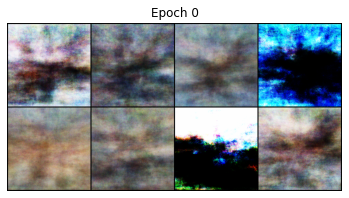

[Epoch 1/10] [Batch 0/1850] [D loss: 0.7142124176025391] [G loss: 1.1159409284591675]
[Epoch 1/10] [Batch 50/1850] [D loss: 0.9002633690834045] [G loss: 0.2864881455898285]
[Epoch 1/10] [Batch 100/1850] [D loss: 0.38794803619384766] [G loss: 1.38267982006073]
[Epoch 1/10] [Batch 150/1850] [D loss: 0.660364031791687] [G loss: 1.9573700428009033]
[Epoch 1/10] [Batch 200/1850] [D loss: 1.162420392036438] [G loss: 0.8842061758041382]
[Epoch 1/10] [Batch 250/1850] [D loss: 0.6655254364013672] [G loss: 0.7130552530288696]
[Epoch 1/10] [Batch 300/1850] [D loss: 0.48923414945602417] [G loss: 1.1542305946350098]
[Epoch 1/10] [Batch 350/1850] [D loss: 0.7429591417312622] [G loss: 0.9817649722099304]
[Epoch 1/10] [Batch 400/1850] [D loss: 0.5277097225189209] [G loss: 1.5670955181121826]
[Epoch 1/10] [Batch 450/1850] [D loss: 0.7683420777320862] [G loss: 0.7579387426376343]
[Epoch 1/10] [Batch 500/1850] [D loss: 0.7108751535415649] [G loss: 0.661494791507721]
[Epoch 1/10] [Batch 550/1850] [D loss:

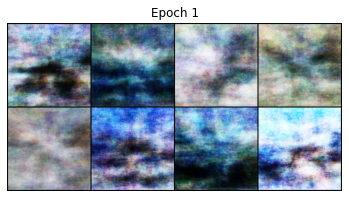

[Epoch 2/10] [Batch 0/1850] [D loss: 0.8981039524078369] [G loss: 0.9459084272384644]
[Epoch 2/10] [Batch 50/1850] [D loss: 0.4895229637622833] [G loss: 1.0328706502914429]
[Epoch 2/10] [Batch 100/1850] [D loss: 0.42409437894821167] [G loss: 1.3122451305389404]
[Epoch 2/10] [Batch 150/1850] [D loss: 0.7603822350502014] [G loss: 0.7336593866348267]
[Epoch 2/10] [Batch 200/1850] [D loss: 0.47884345054626465] [G loss: 0.8944600820541382]
[Epoch 2/10] [Batch 250/1850] [D loss: 0.4705010652542114] [G loss: 1.3573206663131714]
[Epoch 2/10] [Batch 300/1850] [D loss: 0.801163911819458] [G loss: 0.8816462755203247]
[Epoch 2/10] [Batch 350/1850] [D loss: 0.6649091839790344] [G loss: 1.2588969469070435]
[Epoch 2/10] [Batch 400/1850] [D loss: 0.9685879945755005] [G loss: 1.0888314247131348]
[Epoch 2/10] [Batch 450/1850] [D loss: 0.6238371133804321] [G loss: 0.8589566946029663]
[Epoch 2/10] [Batch 500/1850] [D loss: 0.6199962496757507] [G loss: 0.64471435546875]
[Epoch 2/10] [Batch 550/1850] [D los

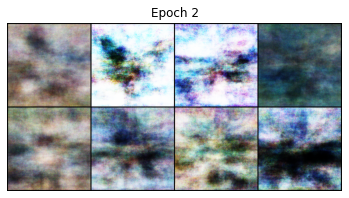

[Epoch 3/10] [Batch 0/1850] [D loss: 0.722054123878479] [G loss: 1.3435416221618652]
[Epoch 3/10] [Batch 50/1850] [D loss: 0.7224028706550598] [G loss: 0.8181139230728149]
[Epoch 3/10] [Batch 100/1850] [D loss: 0.6057394742965698] [G loss: 1.0723967552185059]
[Epoch 3/10] [Batch 150/1850] [D loss: 0.5708099603652954] [G loss: 0.9480764269828796]
[Epoch 3/10] [Batch 200/1850] [D loss: 0.6628313064575195] [G loss: 1.5177944898605347]
[Epoch 3/10] [Batch 250/1850] [D loss: 0.5642658472061157] [G loss: 1.0164722204208374]
[Epoch 3/10] [Batch 300/1850] [D loss: 0.44409072399139404] [G loss: 0.9071584939956665]
[Epoch 3/10] [Batch 350/1850] [D loss: 0.6094380021095276] [G loss: 0.6455404162406921]
[Epoch 3/10] [Batch 400/1850] [D loss: 0.8162369132041931] [G loss: 1.0543711185455322]
[Epoch 3/10] [Batch 450/1850] [D loss: 0.6673083305358887] [G loss: 1.1259077787399292]
[Epoch 3/10] [Batch 500/1850] [D loss: 0.8035392761230469] [G loss: 0.7099801301956177]
[Epoch 3/10] [Batch 550/1850] [D lo

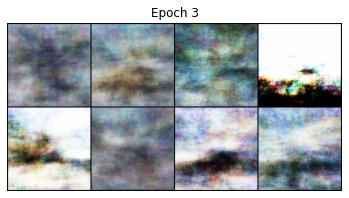

[Epoch 4/10] [Batch 0/1850] [D loss: 0.5460073947906494] [G loss: 0.6922149062156677]
[Epoch 4/10] [Batch 50/1850] [D loss: 0.5308598279953003] [G loss: 0.7377685308456421]
[Epoch 4/10] [Batch 100/1850] [D loss: 0.4340314269065857] [G loss: 2.526740074157715]
[Epoch 4/10] [Batch 150/1850] [D loss: 0.4367418885231018] [G loss: 2.0294275283813477]
[Epoch 4/10] [Batch 200/1850] [D loss: 0.3935975432395935] [G loss: 0.8991414904594421]
[Epoch 4/10] [Batch 250/1850] [D loss: 0.6364933252334595] [G loss: 0.37595856189727783]
[Epoch 4/10] [Batch 300/1850] [D loss: 0.7525343894958496] [G loss: 1.2283923625946045]
[Epoch 4/10] [Batch 350/1850] [D loss: 0.6662452220916748] [G loss: 1.0015180110931396]
[Epoch 4/10] [Batch 400/1850] [D loss: 0.5234901905059814] [G loss: 0.5926055312156677]
[Epoch 4/10] [Batch 450/1850] [D loss: 0.7613378167152405] [G loss: 1.3131685256958008]
[Epoch 4/10] [Batch 500/1850] [D loss: 0.565660834312439] [G loss: 0.9138163328170776]
[Epoch 4/10] [Batch 550/1850] [D los

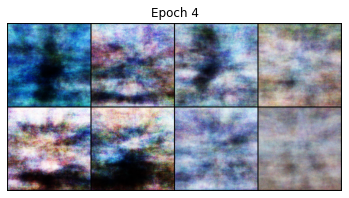

[Epoch 5/10] [Batch 0/1850] [D loss: 1.5148952007293701] [G loss: 1.1793566942214966]
[Epoch 5/10] [Batch 50/1850] [D loss: 0.5973856449127197] [G loss: 0.36830076575279236]
[Epoch 5/10] [Batch 100/1850] [D loss: 0.4646471440792084] [G loss: 0.8874017000198364]
[Epoch 5/10] [Batch 150/1850] [D loss: 0.4777088165283203] [G loss: 1.1083025932312012]
[Epoch 5/10] [Batch 200/1850] [D loss: 0.5203160047531128] [G loss: 0.5938539505004883]
[Epoch 5/10] [Batch 250/1850] [D loss: 0.6793047785758972] [G loss: 0.7025055289268494]
[Epoch 5/10] [Batch 300/1850] [D loss: 0.6943637728691101] [G loss: 0.9641995429992676]
[Epoch 5/10] [Batch 350/1850] [D loss: 0.49134156107902527] [G loss: 0.7797825932502747]
[Epoch 5/10] [Batch 400/1850] [D loss: 0.6867079734802246] [G loss: 1.3336427211761475]
[Epoch 5/10] [Batch 450/1850] [D loss: 0.8248159289360046] [G loss: 1.1283457279205322]
[Epoch 5/10] [Batch 500/1850] [D loss: 0.4325108826160431] [G loss: 1.0116865634918213]
[Epoch 5/10] [Batch 550/1850] [D 

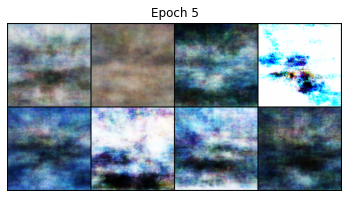

[Epoch 6/10] [Batch 0/1850] [D loss: 0.559741199016571] [G loss: 1.0566251277923584]
[Epoch 6/10] [Batch 50/1850] [D loss: 0.5111782550811768] [G loss: 0.9243693351745605]
[Epoch 6/10] [Batch 100/1850] [D loss: 0.8794719576835632] [G loss: 0.7987107038497925]
[Epoch 6/10] [Batch 150/1850] [D loss: 0.6005979180335999] [G loss: 0.9759849905967712]
[Epoch 6/10] [Batch 200/1850] [D loss: 0.5250891447067261] [G loss: 0.8051090240478516]
[Epoch 6/10] [Batch 250/1850] [D loss: 0.9969494342803955] [G loss: 1.6006205081939697]
[Epoch 6/10] [Batch 300/1850] [D loss: 0.44425779581069946] [G loss: 1.1523891687393188]
[Epoch 6/10] [Batch 350/1850] [D loss: 0.733441174030304] [G loss: 1.165656328201294]
[Epoch 6/10] [Batch 400/1850] [D loss: 0.6687004566192627] [G loss: 0.8740026950836182]
[Epoch 6/10] [Batch 450/1850] [D loss: 0.5748090744018555] [G loss: 0.6366750001907349]
[Epoch 6/10] [Batch 500/1850] [D loss: 0.5266579389572144] [G loss: 1.1516672372817993]
[Epoch 6/10] [Batch 550/1850] [D loss

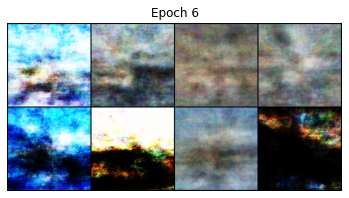

[Epoch 7/10] [Batch 0/1850] [D loss: 0.44933146238327026] [G loss: 0.47749534249305725]
[Epoch 7/10] [Batch 50/1850] [D loss: 1.038823127746582] [G loss: 1.013443112373352]
[Epoch 7/10] [Batch 100/1850] [D loss: 0.4769653379917145] [G loss: 1.185867190361023]
[Epoch 7/10] [Batch 150/1850] [D loss: 0.6273322701454163] [G loss: 0.8281670808792114]
[Epoch 7/10] [Batch 200/1850] [D loss: 0.7366218566894531] [G loss: 1.6592659950256348]
[Epoch 7/10] [Batch 250/1850] [D loss: 0.43730616569519043] [G loss: 0.7337769269943237]
[Epoch 7/10] [Batch 300/1850] [D loss: 0.37916529178619385] [G loss: 1.4839818477630615]
[Epoch 7/10] [Batch 350/1850] [D loss: 0.6487718820571899] [G loss: 1.4241745471954346]
[Epoch 7/10] [Batch 400/1850] [D loss: 0.6774591207504272] [G loss: 0.8057056069374084]
[Epoch 7/10] [Batch 450/1850] [D loss: 0.6270103454589844] [G loss: 1.5961954593658447]
[Epoch 7/10] [Batch 500/1850] [D loss: 0.8992066383361816] [G loss: 0.6436570882797241]
[Epoch 7/10] [Batch 550/1850] [D l

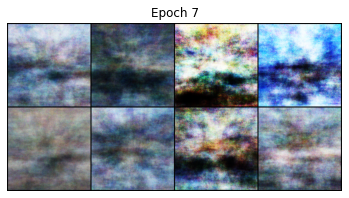

[Epoch 8/10] [Batch 0/1850] [D loss: 0.6196334362030029] [G loss: 0.7840129137039185]
[Epoch 8/10] [Batch 50/1850] [D loss: 0.692811131477356] [G loss: 0.638195276260376]
[Epoch 8/10] [Batch 100/1850] [D loss: 0.9607644081115723] [G loss: 1.065608024597168]
[Epoch 8/10] [Batch 150/1850] [D loss: 0.3267115354537964] [G loss: 0.9879864454269409]
[Epoch 8/10] [Batch 200/1850] [D loss: 0.567339301109314] [G loss: 0.8152052164077759]
[Epoch 8/10] [Batch 250/1850] [D loss: 0.685702919960022] [G loss: 0.9403859376907349]
[Epoch 8/10] [Batch 300/1850] [D loss: 0.3268111050128937] [G loss: 0.8432421684265137]
[Epoch 8/10] [Batch 350/1850] [D loss: 0.6204801797866821] [G loss: 0.5589431524276733]
[Epoch 8/10] [Batch 400/1850] [D loss: 0.47089093923568726] [G loss: 1.0833580493927002]
[Epoch 8/10] [Batch 450/1850] [D loss: 1.105494737625122] [G loss: 0.6917009949684143]
[Epoch 8/10] [Batch 500/1850] [D loss: 0.4251285791397095] [G loss: 0.5434608459472656]
[Epoch 8/10] [Batch 550/1850] [D loss: 0

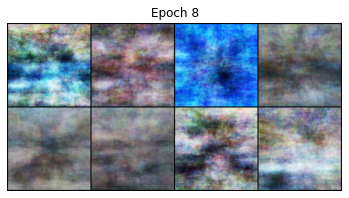

[Epoch 9/10] [Batch 0/1850] [D loss: 0.7857425808906555] [G loss: 0.94272381067276]
[Epoch 9/10] [Batch 50/1850] [D loss: 0.6114956736564636] [G loss: 0.7620043158531189]
[Epoch 9/10] [Batch 100/1850] [D loss: 0.3497273623943329] [G loss: 1.0281119346618652]
[Epoch 9/10] [Batch 150/1850] [D loss: 0.6042259931564331] [G loss: 1.6808958053588867]
[Epoch 9/10] [Batch 200/1850] [D loss: 0.4388085901737213] [G loss: 0.7939556837081909]
[Epoch 9/10] [Batch 250/1850] [D loss: 0.6787322759628296] [G loss: 1.2831895351409912]
[Epoch 9/10] [Batch 300/1850] [D loss: 0.7589834928512573] [G loss: 0.7428039312362671]
[Epoch 9/10] [Batch 350/1850] [D loss: 0.5897926092147827] [G loss: 0.9813212156295776]
[Epoch 9/10] [Batch 400/1850] [D loss: 0.6585485339164734] [G loss: 0.6053277254104614]
[Epoch 9/10] [Batch 450/1850] [D loss: 1.1770176887512207] [G loss: 1.4592714309692383]
[Epoch 9/10] [Batch 500/1850] [D loss: 0.7758469581604004] [G loss: 1.4825478792190552]
[Epoch 9/10] [Batch 550/1850] [D loss

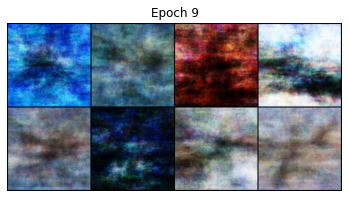

In [17]:
train(generator, discriminator, dataloader, epochs=10)

[Epoch 0/10] [Batch 0/1850] [D loss: 0.9055194854736328] [G loss: 1.20620858669281]
[Epoch 0/10] [Batch 50/1850] [D loss: 0.9657387733459473] [G loss: 0.9132074117660522]
[Epoch 0/10] [Batch 100/1850] [D loss: 0.5579941272735596] [G loss: 1.5374934673309326]
[Epoch 0/10] [Batch 150/1850] [D loss: 0.7508243322372437] [G loss: 0.8175179958343506]
[Epoch 0/10] [Batch 200/1850] [D loss: 0.38779422640800476] [G loss: 1.8469152450561523]
[Epoch 0/10] [Batch 250/1850] [D loss: 0.32503432035446167] [G loss: 0.6128966808319092]
[Epoch 0/10] [Batch 300/1850] [D loss: 0.5800455808639526] [G loss: 0.6756554841995239]
[Epoch 0/10] [Batch 350/1850] [D loss: 0.7161298394203186] [G loss: 1.3945083618164062]
[Epoch 0/10] [Batch 400/1850] [D loss: 1.0978096723556519] [G loss: 1.1618337631225586]
[Epoch 0/10] [Batch 450/1850] [D loss: 0.6883639097213745] [G loss: 1.248551607131958]
[Epoch 0/10] [Batch 500/1850] [D loss: 0.5639820098876953] [G loss: 0.9793368577957153]
[Epoch 0/10] [Batch 550/1850] [D los

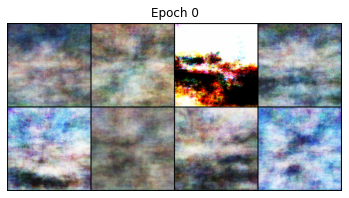

[Epoch 1/10] [Batch 0/1850] [D loss: 0.6722184419631958] [G loss: 0.69208824634552]
[Epoch 1/10] [Batch 50/1850] [D loss: 0.4607440233230591] [G loss: 1.122504472732544]
[Epoch 1/10] [Batch 100/1850] [D loss: 1.5478956699371338] [G loss: 0.7865400314331055]
[Epoch 1/10] [Batch 150/1850] [D loss: 0.46218258142471313] [G loss: 0.5270586013793945]
[Epoch 1/10] [Batch 200/1850] [D loss: 0.6953359246253967] [G loss: 1.3136370182037354]
[Epoch 1/10] [Batch 250/1850] [D loss: 0.8577988147735596] [G loss: 1.1329500675201416]
[Epoch 1/10] [Batch 300/1850] [D loss: 0.5551010370254517] [G loss: 1.1460278034210205]
[Epoch 1/10] [Batch 350/1850] [D loss: 0.42368367314338684] [G loss: 0.8487107753753662]
[Epoch 1/10] [Batch 400/1850] [D loss: 0.7069509029388428] [G loss: 0.8308854103088379]
[Epoch 1/10] [Batch 450/1850] [D loss: 0.431494802236557] [G loss: 1.0445613861083984]
[Epoch 1/10] [Batch 500/1850] [D loss: 0.770686686038971] [G loss: 1.0132544040679932]
[Epoch 1/10] [Batch 550/1850] [D loss:

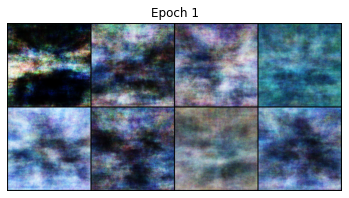

[Epoch 2/10] [Batch 0/1850] [D loss: 0.6650638580322266] [G loss: 1.4208985567092896]
[Epoch 2/10] [Batch 50/1850] [D loss: 0.7319335341453552] [G loss: 0.8219704031944275]
[Epoch 2/10] [Batch 100/1850] [D loss: 0.7281960844993591] [G loss: 0.9085594415664673]
[Epoch 2/10] [Batch 150/1850] [D loss: 0.44471263885498047] [G loss: 1.2937462329864502]
[Epoch 2/10] [Batch 200/1850] [D loss: 1.124394178390503] [G loss: 0.7589056491851807]
[Epoch 2/10] [Batch 250/1850] [D loss: 0.342624694108963] [G loss: 0.925976037979126]
[Epoch 2/10] [Batch 300/1850] [D loss: 0.8216776847839355] [G loss: 1.1828932762145996]
[Epoch 2/10] [Batch 350/1850] [D loss: 0.5999622344970703] [G loss: 0.846767246723175]
[Epoch 2/10] [Batch 400/1850] [D loss: 0.5105629563331604] [G loss: 1.9866445064544678]
[Epoch 2/10] [Batch 450/1850] [D loss: 0.7044754028320312] [G loss: 1.061061978340149]
[Epoch 2/10] [Batch 500/1850] [D loss: 0.5202594995498657] [G loss: 0.9027153849601746]
[Epoch 2/10] [Batch 550/1850] [D loss: 

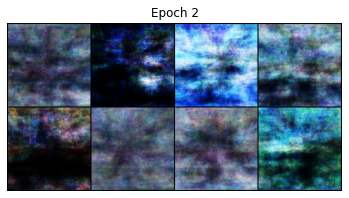

[Epoch 3/10] [Batch 0/1850] [D loss: 0.5353999733924866] [G loss: 1.253827452659607]
[Epoch 3/10] [Batch 50/1850] [D loss: 0.5918639898300171] [G loss: 1.3073272705078125]
[Epoch 3/10] [Batch 100/1850] [D loss: 0.5512102842330933] [G loss: 1.3552302122116089]
[Epoch 3/10] [Batch 150/1850] [D loss: 0.5064595937728882] [G loss: 0.8541646003723145]
[Epoch 3/10] [Batch 200/1850] [D loss: 0.75175940990448] [G loss: 1.1692368984222412]
[Epoch 3/10] [Batch 250/1850] [D loss: 0.49389705061912537] [G loss: 0.9589686393737793]
[Epoch 3/10] [Batch 300/1850] [D loss: 0.43555396795272827] [G loss: 1.3711457252502441]
[Epoch 3/10] [Batch 350/1850] [D loss: 0.7141695022583008] [G loss: 0.9497805833816528]
[Epoch 3/10] [Batch 400/1850] [D loss: 0.60791015625] [G loss: 1.4676296710968018]
[Epoch 3/10] [Batch 450/1850] [D loss: 0.589679479598999] [G loss: 1.5483349561691284]
[Epoch 3/10] [Batch 500/1850] [D loss: 0.41016891598701477] [G loss: 0.8172221183776855]
[Epoch 3/10] [Batch 550/1850] [D loss: 0.

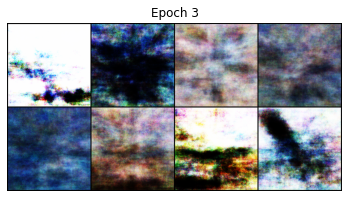

[Epoch 4/10] [Batch 0/1850] [D loss: 0.668715238571167] [G loss: 0.903766393661499]
[Epoch 4/10] [Batch 50/1850] [D loss: 0.9187963008880615] [G loss: 0.9811586737632751]
[Epoch 4/10] [Batch 100/1850] [D loss: 0.7688442468643188] [G loss: 1.417785882949829]
[Epoch 4/10] [Batch 150/1850] [D loss: 0.6500039100646973] [G loss: 1.4096192121505737]
[Epoch 4/10] [Batch 200/1850] [D loss: 0.4184863865375519] [G loss: 1.3295133113861084]
[Epoch 4/10] [Batch 250/1850] [D loss: 0.43102049827575684] [G loss: 0.9857436418533325]
[Epoch 4/10] [Batch 300/1850] [D loss: 0.40199369192123413] [G loss: 1.3670488595962524]
[Epoch 4/10] [Batch 350/1850] [D loss: 0.9896318912506104] [G loss: 1.9034249782562256]
[Epoch 4/10] [Batch 400/1850] [D loss: 0.6334707736968994] [G loss: 1.0887960195541382]
[Epoch 4/10] [Batch 450/1850] [D loss: 0.6992068290710449] [G loss: 1.452594518661499]
[Epoch 4/10] [Batch 500/1850] [D loss: 0.3510552644729614] [G loss: 0.7735103368759155]
[Epoch 4/10] [Batch 550/1850] [D loss

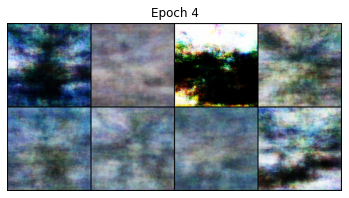

[Epoch 5/10] [Batch 0/1850] [D loss: 0.7766395807266235] [G loss: 0.6767934560775757]
[Epoch 5/10] [Batch 50/1850] [D loss: 0.6171047687530518] [G loss: 1.0376815795898438]
[Epoch 5/10] [Batch 100/1850] [D loss: 0.5675182342529297] [G loss: 1.5662282705307007]
[Epoch 5/10] [Batch 150/1850] [D loss: 0.8941054344177246] [G loss: 0.842151403427124]
[Epoch 5/10] [Batch 200/1850] [D loss: 0.5895233154296875] [G loss: 1.5012238025665283]
[Epoch 5/10] [Batch 250/1850] [D loss: 0.36504286527633667] [G loss: 1.2129604816436768]
[Epoch 5/10] [Batch 300/1850] [D loss: 0.5619603395462036] [G loss: 1.4479122161865234]
[Epoch 5/10] [Batch 350/1850] [D loss: 0.5774967074394226] [G loss: 0.8872907161712646]
[Epoch 5/10] [Batch 400/1850] [D loss: 0.43274182081222534] [G loss: 1.0046522617340088]
[Epoch 5/10] [Batch 450/1850] [D loss: 0.4156709313392639] [G loss: 1.604537010192871]
[Epoch 5/10] [Batch 500/1850] [D loss: 0.2095208764076233] [G loss: 0.2930210828781128]
[Epoch 5/10] [Batch 550/1850] [D lo

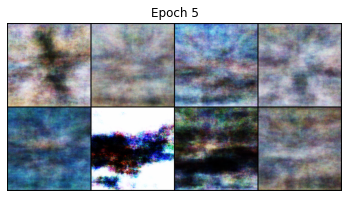

[Epoch 6/10] [Batch 0/1850] [D loss: 0.674949049949646] [G loss: 1.0678975582122803]
[Epoch 6/10] [Batch 50/1850] [D loss: 1.1063859462738037] [G loss: 1.264962911605835]
[Epoch 6/10] [Batch 100/1850] [D loss: 0.5049649477005005] [G loss: 0.7875860929489136]
[Epoch 6/10] [Batch 150/1850] [D loss: 0.8512091636657715] [G loss: 1.0090597867965698]
[Epoch 6/10] [Batch 200/1850] [D loss: 0.5994104146957397] [G loss: 1.3981882333755493]
[Epoch 6/10] [Batch 250/1850] [D loss: 0.42886874079704285] [G loss: 0.5221467018127441]
[Epoch 6/10] [Batch 300/1850] [D loss: 0.7189333438873291] [G loss: 1.087267518043518]
[Epoch 6/10] [Batch 350/1850] [D loss: 0.5094681978225708] [G loss: 1.4582401514053345]
[Epoch 6/10] [Batch 400/1850] [D loss: 0.6630107164382935] [G loss: 1.563932180404663]
[Epoch 6/10] [Batch 450/1850] [D loss: 0.6276681423187256] [G loss: 0.9271997213363647]
[Epoch 6/10] [Batch 500/1850] [D loss: 0.41964277625083923] [G loss: 1.2202699184417725]
[Epoch 6/10] [Batch 550/1850] [D loss

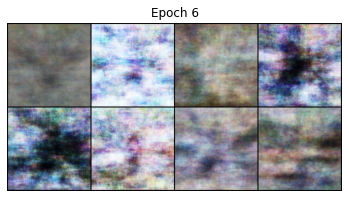

[Epoch 7/10] [Batch 0/1850] [D loss: 0.8569639325141907] [G loss: 1.4420664310455322]
[Epoch 7/10] [Batch 50/1850] [D loss: 0.8803101778030396] [G loss: 1.337052583694458]
[Epoch 7/10] [Batch 100/1850] [D loss: 0.5685732960700989] [G loss: 1.296830177307129]
[Epoch 7/10] [Batch 150/1850] [D loss: 0.6306642889976501] [G loss: 1.3088452816009521]
[Epoch 7/10] [Batch 200/1850] [D loss: 0.5232287049293518] [G loss: 1.0684916973114014]
[Epoch 7/10] [Batch 250/1850] [D loss: 0.4495943784713745] [G loss: 1.2668578624725342]
[Epoch 7/10] [Batch 300/1850] [D loss: 0.9610700607299805] [G loss: 0.8034828901290894]
[Epoch 7/10] [Batch 350/1850] [D loss: 0.3712911903858185] [G loss: 0.9428914785385132]
[Epoch 7/10] [Batch 400/1850] [D loss: 0.5378692150115967] [G loss: 1.276163935661316]
[Epoch 7/10] [Batch 450/1850] [D loss: 0.48532018065452576] [G loss: 1.4479286670684814]
[Epoch 7/10] [Batch 500/1850] [D loss: 0.8553918600082397] [G loss: 1.2014580965042114]
[Epoch 7/10] [Batch 550/1850] [D loss

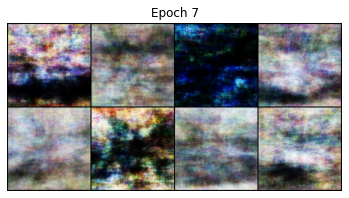

[Epoch 8/10] [Batch 0/1850] [D loss: 0.7096054553985596] [G loss: 1.2997362613677979]
[Epoch 8/10] [Batch 50/1850] [D loss: 0.6088676452636719] [G loss: 1.2157771587371826]
[Epoch 8/10] [Batch 100/1850] [D loss: 0.4878649413585663] [G loss: 1.0242959260940552]
[Epoch 8/10] [Batch 150/1850] [D loss: 0.6915770769119263] [G loss: 1.5175248384475708]
[Epoch 8/10] [Batch 200/1850] [D loss: 0.8194396495819092] [G loss: 1.0932625532150269]
[Epoch 8/10] [Batch 250/1850] [D loss: 0.5795226097106934] [G loss: 1.5994210243225098]
[Epoch 8/10] [Batch 300/1850] [D loss: 0.2799583077430725] [G loss: 1.3653087615966797]
[Epoch 8/10] [Batch 350/1850] [D loss: 0.6456881761550903] [G loss: 0.8437290191650391]
[Epoch 8/10] [Batch 400/1850] [D loss: 0.6384508609771729] [G loss: 1.130347490310669]
[Epoch 8/10] [Batch 450/1850] [D loss: 0.4161229729652405] [G loss: 1.7121524810791016]
[Epoch 8/10] [Batch 500/1850] [D loss: 0.4934524595737457] [G loss: 0.8477301001548767]
[Epoch 8/10] [Batch 550/1850] [D los

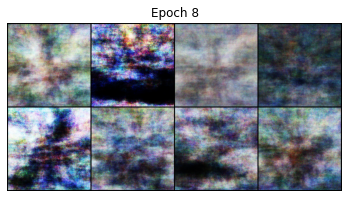

[Epoch 9/10] [Batch 0/1850] [D loss: 0.7369718551635742] [G loss: 0.8506323099136353]
[Epoch 9/10] [Batch 50/1850] [D loss: 0.7967997789382935] [G loss: 1.7064028978347778]
[Epoch 9/10] [Batch 100/1850] [D loss: 0.2944408059120178] [G loss: 0.9914716482162476]
[Epoch 9/10] [Batch 150/1850] [D loss: 0.40437713265419006] [G loss: 1.2372030019760132]
[Epoch 9/10] [Batch 200/1850] [D loss: 0.4213047921657562] [G loss: 1.086323857307434]
[Epoch 9/10] [Batch 250/1850] [D loss: 0.9995165467262268] [G loss: 0.9579435586929321]
[Epoch 9/10] [Batch 300/1850] [D loss: 0.36394909024238586] [G loss: 0.9379652738571167]
[Epoch 9/10] [Batch 350/1850] [D loss: 0.8194509148597717] [G loss: 1.1488059759140015]
[Epoch 9/10] [Batch 400/1850] [D loss: 0.7014679312705994] [G loss: 0.8684242367744446]
[Epoch 9/10] [Batch 450/1850] [D loss: 0.9592118263244629] [G loss: 1.8002794981002808]
[Epoch 9/10] [Batch 500/1850] [D loss: 0.7655501961708069] [G loss: 0.622776210308075]
[Epoch 9/10] [Batch 550/1850] [D lo

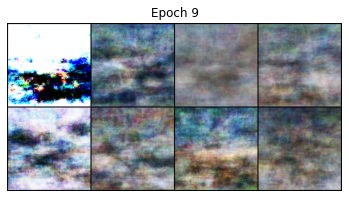

In [18]:
 train(generator, discriminator, dataloader, epochs=10)

[Epoch 0/100] [Batch 0/1850] [D loss: 0.8780627250671387] [G loss: 1.4607787132263184]
[Epoch 0/100] [Batch 50/1850] [D loss: 0.28688475489616394] [G loss: 1.4475297927856445]
[Epoch 0/100] [Batch 100/1850] [D loss: 0.8135043382644653] [G loss: 1.2392590045928955]
[Epoch 0/100] [Batch 150/1850] [D loss: 0.5561279058456421] [G loss: 0.5109536647796631]
[Epoch 0/100] [Batch 200/1850] [D loss: 0.3318699598312378] [G loss: 0.6252829432487488]
[Epoch 0/100] [Batch 250/1850] [D loss: 0.543566107749939] [G loss: 1.1923590898513794]
[Epoch 0/100] [Batch 300/1850] [D loss: 0.6443827152252197] [G loss: 0.9694964289665222]
[Epoch 0/100] [Batch 350/1850] [D loss: 0.3444664478302002] [G loss: 1.5983883142471313]
[Epoch 0/100] [Batch 400/1850] [D loss: 0.3637600541114807] [G loss: 1.1641693115234375]
[Epoch 0/100] [Batch 450/1850] [D loss: 0.8660329580307007] [G loss: 1.0445127487182617]
[Epoch 0/100] [Batch 500/1850] [D loss: 0.3105561137199402] [G loss: 0.8410229682922363]
[Epoch 0/100] [Batch 550

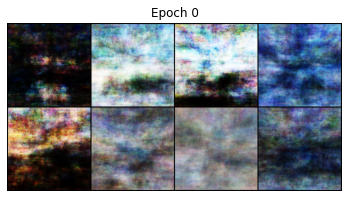

[Epoch 1/100] [Batch 0/1850] [D loss: 0.4179701507091522] [G loss: 1.1802972555160522]
[Epoch 1/100] [Batch 50/1850] [D loss: 0.6233456134796143] [G loss: 0.9683237075805664]
[Epoch 1/100] [Batch 100/1850] [D loss: 0.5056275725364685] [G loss: 0.9235439896583557]
[Epoch 1/100] [Batch 150/1850] [D loss: 0.3564754128456116] [G loss: 0.7916052341461182]
[Epoch 1/100] [Batch 200/1850] [D loss: 0.07832767069339752] [G loss: 1.502077341079712]
[Epoch 1/100] [Batch 250/1850] [D loss: 0.2533288300037384] [G loss: 1.2834808826446533]
[Epoch 1/100] [Batch 300/1850] [D loss: 0.6296903491020203] [G loss: 0.6772136092185974]
[Epoch 1/100] [Batch 350/1850] [D loss: 0.40496712923049927] [G loss: 0.4727417826652527]
[Epoch 1/100] [Batch 400/1850] [D loss: 0.820939302444458] [G loss: 1.7224416732788086]
[Epoch 1/100] [Batch 450/1850] [D loss: 0.8976681232452393] [G loss: 1.2907977104187012]
[Epoch 1/100] [Batch 500/1850] [D loss: 0.6115503311157227] [G loss: 1.3553907871246338]
[Epoch 1/100] [Batch 550

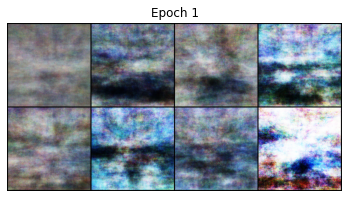

[Epoch 2/100] [Batch 0/1850] [D loss: 0.38720712065696716] [G loss: 1.2969601154327393]
[Epoch 2/100] [Batch 50/1850] [D loss: 0.4112507998943329] [G loss: 2.3410401344299316]
[Epoch 2/100] [Batch 100/1850] [D loss: 0.5637086033821106] [G loss: 1.8139833211898804]
[Epoch 2/100] [Batch 150/1850] [D loss: 0.6392512917518616] [G loss: 1.2178293466567993]
[Epoch 2/100] [Batch 200/1850] [D loss: 0.6801564693450928] [G loss: 1.6109375953674316]
[Epoch 2/100] [Batch 250/1850] [D loss: 0.42348513007164] [G loss: 1.715816617012024]
[Epoch 2/100] [Batch 300/1850] [D loss: 0.29891300201416016] [G loss: 1.3132213354110718]
[Epoch 2/100] [Batch 350/1850] [D loss: 0.46780288219451904] [G loss: 1.1574311256408691]
[Epoch 2/100] [Batch 400/1850] [D loss: 0.5846837759017944] [G loss: 0.38452446460723877]
[Epoch 2/100] [Batch 450/1850] [D loss: 0.9126101136207581] [G loss: 0.754819393157959]
[Epoch 2/100] [Batch 500/1850] [D loss: 0.4364141523838043] [G loss: 1.6602423191070557]
[Epoch 2/100] [Batch 550

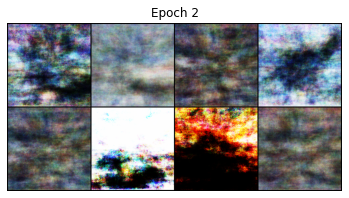

[Epoch 3/100] [Batch 0/1850] [D loss: 0.44532546401023865] [G loss: 0.9796934127807617]
[Epoch 3/100] [Batch 50/1850] [D loss: 0.6219500303268433] [G loss: 1.004019856452942]
[Epoch 3/100] [Batch 100/1850] [D loss: 0.7125796675682068] [G loss: 0.8552374839782715]
[Epoch 3/100] [Batch 150/1850] [D loss: 0.4348505139350891] [G loss: 1.0917775630950928]
[Epoch 3/100] [Batch 200/1850] [D loss: 0.79867023229599] [G loss: 1.4637494087219238]
[Epoch 3/100] [Batch 250/1850] [D loss: 0.533850908279419] [G loss: 1.6961909532546997]
[Epoch 3/100] [Batch 300/1850] [D loss: 0.23714172840118408] [G loss: 1.3910164833068848]
[Epoch 3/100] [Batch 350/1850] [D loss: 0.6801203489303589] [G loss: 1.0161328315734863]
[Epoch 3/100] [Batch 400/1850] [D loss: 0.3426293730735779] [G loss: 0.9742265939712524]
[Epoch 3/100] [Batch 450/1850] [D loss: 0.3698965907096863] [G loss: 1.825685977935791]
[Epoch 3/100] [Batch 500/1850] [D loss: 0.7758691310882568] [G loss: 1.491043210029602]
[Epoch 3/100] [Batch 550/185

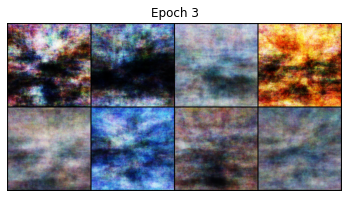

[Epoch 4/100] [Batch 0/1850] [D loss: 0.4454079866409302] [G loss: 1.4336504936218262]
[Epoch 4/100] [Batch 50/1850] [D loss: 0.5510337352752686] [G loss: 1.6989049911499023]
[Epoch 4/100] [Batch 100/1850] [D loss: 0.568246066570282] [G loss: 1.0025012493133545]
[Epoch 4/100] [Batch 150/1850] [D loss: 0.2680315375328064] [G loss: 0.8287436366081238]
[Epoch 4/100] [Batch 200/1850] [D loss: 0.4134727716445923] [G loss: 0.7931431531906128]
[Epoch 4/100] [Batch 250/1850] [D loss: 0.626362144947052] [G loss: 0.9250729084014893]
[Epoch 4/100] [Batch 300/1850] [D loss: 1.1357812881469727] [G loss: 2.5195300579071045]
[Epoch 4/100] [Batch 350/1850] [D loss: 0.6763443946838379] [G loss: 1.0273562669754028]
[Epoch 4/100] [Batch 400/1850] [D loss: 0.8073416948318481] [G loss: 1.1613669395446777]
[Epoch 4/100] [Batch 450/1850] [D loss: 0.6619933843612671] [G loss: 2.470604419708252]
[Epoch 4/100] [Batch 500/1850] [D loss: 1.1563453674316406] [G loss: 1.1489331722259521]
[Epoch 4/100] [Batch 550/18

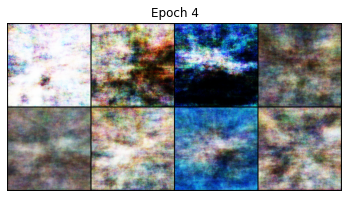

[Epoch 5/100] [Batch 0/1850] [D loss: 0.37072062492370605] [G loss: 0.8982549905776978]
[Epoch 5/100] [Batch 50/1850] [D loss: 0.75379478931427] [G loss: 1.252213954925537]
[Epoch 5/100] [Batch 100/1850] [D loss: 0.6025280952453613] [G loss: 0.608582615852356]
[Epoch 5/100] [Batch 150/1850] [D loss: 0.6899746656417847] [G loss: 1.4147377014160156]
[Epoch 5/100] [Batch 200/1850] [D loss: 0.4759376347064972] [G loss: 1.294050931930542]
[Epoch 5/100] [Batch 250/1850] [D loss: 0.6844696998596191] [G loss: 1.1850770711898804]
[Epoch 5/100] [Batch 300/1850] [D loss: 0.4510432779788971] [G loss: 0.8657094240188599]
[Epoch 5/100] [Batch 350/1850] [D loss: 0.6276388168334961] [G loss: 1.0175650119781494]
[Epoch 5/100] [Batch 400/1850] [D loss: 0.38508307933807373] [G loss: 1.2698036432266235]
[Epoch 5/100] [Batch 450/1850] [D loss: 0.4808300733566284] [G loss: 0.8732075691223145]
[Epoch 5/100] [Batch 500/1850] [D loss: 0.7003936767578125] [G loss: 1.8153795003890991]
[Epoch 5/100] [Batch 550/18

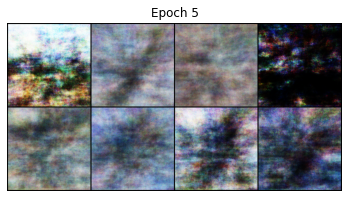

[Epoch 6/100] [Batch 0/1850] [D loss: 0.7837544679641724] [G loss: 1.4875801801681519]
[Epoch 6/100] [Batch 50/1850] [D loss: 0.3649943470954895] [G loss: 1.657295823097229]
[Epoch 6/100] [Batch 100/1850] [D loss: 0.7172526717185974] [G loss: 0.904146671295166]
[Epoch 6/100] [Batch 150/1850] [D loss: 0.4347670078277588] [G loss: 1.7562286853790283]
[Epoch 6/100] [Batch 200/1850] [D loss: 0.5143896341323853] [G loss: 1.0434668064117432]
[Epoch 6/100] [Batch 250/1850] [D loss: 0.36204445362091064] [G loss: 1.2268177270889282]
[Epoch 6/100] [Batch 300/1850] [D loss: 0.6681492328643799] [G loss: 0.8526685237884521]
[Epoch 6/100] [Batch 350/1850] [D loss: 0.6114439368247986] [G loss: 1.4813870191574097]
[Epoch 6/100] [Batch 400/1850] [D loss: 0.571313738822937] [G loss: 2.09291934967041]
[Epoch 6/100] [Batch 450/1850] [D loss: 0.6611231565475464] [G loss: 0.8908204436302185]
[Epoch 6/100] [Batch 500/1850] [D loss: 0.5046557188034058] [G loss: 1.4969127178192139]
[Epoch 6/100] [Batch 550/185

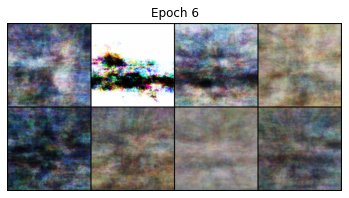

[Epoch 7/100] [Batch 0/1850] [D loss: 0.28327423334121704] [G loss: 1.140020728111267]
[Epoch 7/100] [Batch 50/1850] [D loss: 0.5388118624687195] [G loss: 0.946514368057251]
[Epoch 7/100] [Batch 100/1850] [D loss: 0.33530643582344055] [G loss: 0.9260339140892029]
[Epoch 7/100] [Batch 150/1850] [D loss: 0.589415431022644] [G loss: 1.336248755455017]
[Epoch 7/100] [Batch 200/1850] [D loss: 0.7365107536315918] [G loss: 1.7375500202178955]
[Epoch 7/100] [Batch 250/1850] [D loss: 1.164139747619629] [G loss: 1.1761161088943481]
[Epoch 7/100] [Batch 300/1850] [D loss: 0.37993180751800537] [G loss: 0.6443839073181152]
[Epoch 7/100] [Batch 350/1850] [D loss: 0.42710262537002563] [G loss: 0.9343751668930054]
[Epoch 7/100] [Batch 400/1850] [D loss: 0.5038002729415894] [G loss: 1.7635990381240845]
[Epoch 7/100] [Batch 450/1850] [D loss: 0.5278272032737732] [G loss: 1.4589641094207764]
[Epoch 7/100] [Batch 500/1850] [D loss: 0.15177252888679504] [G loss: 2.0841445922851562]
[Epoch 7/100] [Batch 550

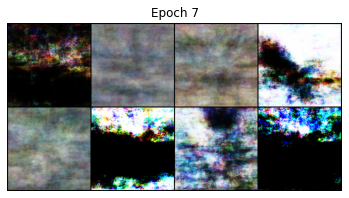

[Epoch 8/100] [Batch 0/1850] [D loss: 0.8865748047828674] [G loss: 0.9358296394348145]
[Epoch 8/100] [Batch 50/1850] [D loss: 0.7194597721099854] [G loss: 1.0565530061721802]
[Epoch 8/100] [Batch 100/1850] [D loss: 0.2980220913887024] [G loss: 0.9713366031646729]
[Epoch 8/100] [Batch 150/1850] [D loss: 0.6525275111198425] [G loss: 1.329185962677002]
[Epoch 8/100] [Batch 200/1850] [D loss: 0.5259007811546326] [G loss: 0.7714695930480957]
[Epoch 8/100] [Batch 250/1850] [D loss: 0.5862188935279846] [G loss: 1.5712765455245972]
[Epoch 8/100] [Batch 300/1850] [D loss: 0.5443496704101562] [G loss: 0.7338100671768188]
[Epoch 8/100] [Batch 350/1850] [D loss: 0.2435102015733719] [G loss: 1.56094229221344]
[Epoch 8/100] [Batch 400/1850] [D loss: 0.852473795413971] [G loss: 1.4325308799743652]
[Epoch 8/100] [Batch 450/1850] [D loss: 0.30911052227020264] [G loss: 1.517481803894043]
[Epoch 8/100] [Batch 500/1850] [D loss: 0.5031944513320923] [G loss: 1.4652070999145508]
[Epoch 8/100] [Batch 550/185

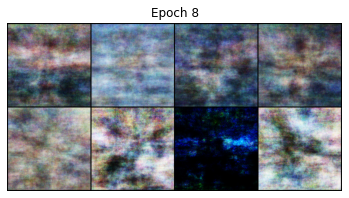

[Epoch 9/100] [Batch 0/1850] [D loss: 0.6894752979278564] [G loss: 1.0693861246109009]
[Epoch 9/100] [Batch 50/1850] [D loss: 0.735910952091217] [G loss: 2.4112119674682617]
[Epoch 9/100] [Batch 100/1850] [D loss: 0.3942616879940033] [G loss: 1.5555074214935303]
[Epoch 9/100] [Batch 150/1850] [D loss: 0.7622402906417847] [G loss: 1.4723262786865234]
[Epoch 9/100] [Batch 200/1850] [D loss: 0.21029382944107056] [G loss: 2.167863368988037]
[Epoch 9/100] [Batch 250/1850] [D loss: 0.4726325273513794] [G loss: 2.047417402267456]
[Epoch 9/100] [Batch 300/1850] [D loss: 0.3947405219078064] [G loss: 0.8449360132217407]
[Epoch 9/100] [Batch 350/1850] [D loss: 0.2915375232696533] [G loss: 1.219049334526062]
[Epoch 9/100] [Batch 400/1850] [D loss: 0.6151422262191772] [G loss: 1.3276798725128174]
[Epoch 9/100] [Batch 450/1850] [D loss: 0.2767793834209442] [G loss: 1.0900614261627197]
[Epoch 9/100] [Batch 500/1850] [D loss: 0.3253329396247864] [G loss: 1.4820685386657715]


In [ ]:
  train(generator, discriminator, dataloader, epochs=100)